<a href="https://colab.research.google.com/github/neonkitchen/generative-precision-recall-metric-pytorch/blob/master/gen_pr_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improved Precision and Recall Metric for Assessing Generative Models

##Background

>The following implementation explores the improved precision-recall metric outlined in the Nvidia Research paper [Improved Precision and Recall Metric for Assessing Generative Models](https://arxiv.org/pdf/1904.06991v3.pdf) by Kynkäänniemi et al. [1]. 
>
>Generative models, such as Generative Adversarial Networks (GAN) and Variational Autoencoders (VAE), produce synthetic images from a learnt training data manifold. The goal of these models is to generate samples indistinguishable from the training data.
>
>Despite the recent rapid progress in generative models, assessment of the samples produced by generative models continues to be challenging. Samples produced are  often assessed subjectively by a human observer. This is not particularly scientific and introduces the risk of human bias. In particular there is a risk of selection bias: it is likely that a human observer will "cherry pick" several samples to base their assessment on. Conclusions drawn are thus unlikely to assess a generative model in totality. 
>
>Automatic assessments of the quality and coverage of synthetic samples from generative models are imperative for continued algorithm research and progress. The evaluation metric presented by Kynkäänniemi et al. can separately and reliably measure both of these aspects in image generation tasks. This is done by forming **explicit, non-parametric representations of the manifolds of real and generated sample data.**
>
>The metric is independent of the model used to generate the synthetic images and allows different generative algorithms to be objectively compared. In particular, it is worth noting that the metric is independent of the generative model's training process, as such, there is little risk that the generative model's training process will "game" the metric.




# Manifold learning

>When learning a manifold for sampling purposes, as done in generative modelling, Kynkäänniemi et al. noted that two seperate goals emerge:
>
>1.   Resultant samples drawn should be **“high quality”**, remaining faithful to training data 
>2.   Resultant samples drawn should have **variation** that matches the training data 

# Shortfall of current metrics

>Commonly used metrics such as Fréchet Inception Distance (FID), Inception Score (IS), and Kernel Inception Distance (KID), group these two aspects to a **single value without a clear tradeoff**.

# Previous work on precision recall in generative models

>Previous metrics from Sajjadi et al. [2] introduced classical concepts of *pression* and *recall* to generative model assessment. As such, the quality of the generated samples using two separate components: 
>
>1.   Precision:  corresponds to *average* sample quality
>2.   Recall: coverage of sample distribution
>
>Sajjadi et al. [2] computed these components through relative probability densitites of two distributions. 
>
>This paper noted that this introduces ambiguity that Sajjadi et al. [2] resolved by modeling a continuum of precision/recall values, with the extrema correspond to the classic deﬁnitions. The algorithm, however, cannot reliably estimate the extrema because of its reliance on relative densities. An example of this when large numbers of samples are packed together, as is the case of mode collapse or truncation.
>
>
>
>
>
>
>
>Figure 1 below is a two-dimension manifold representation of precision and recall [[1]](https://arxiv.org/abs/1904.06991).



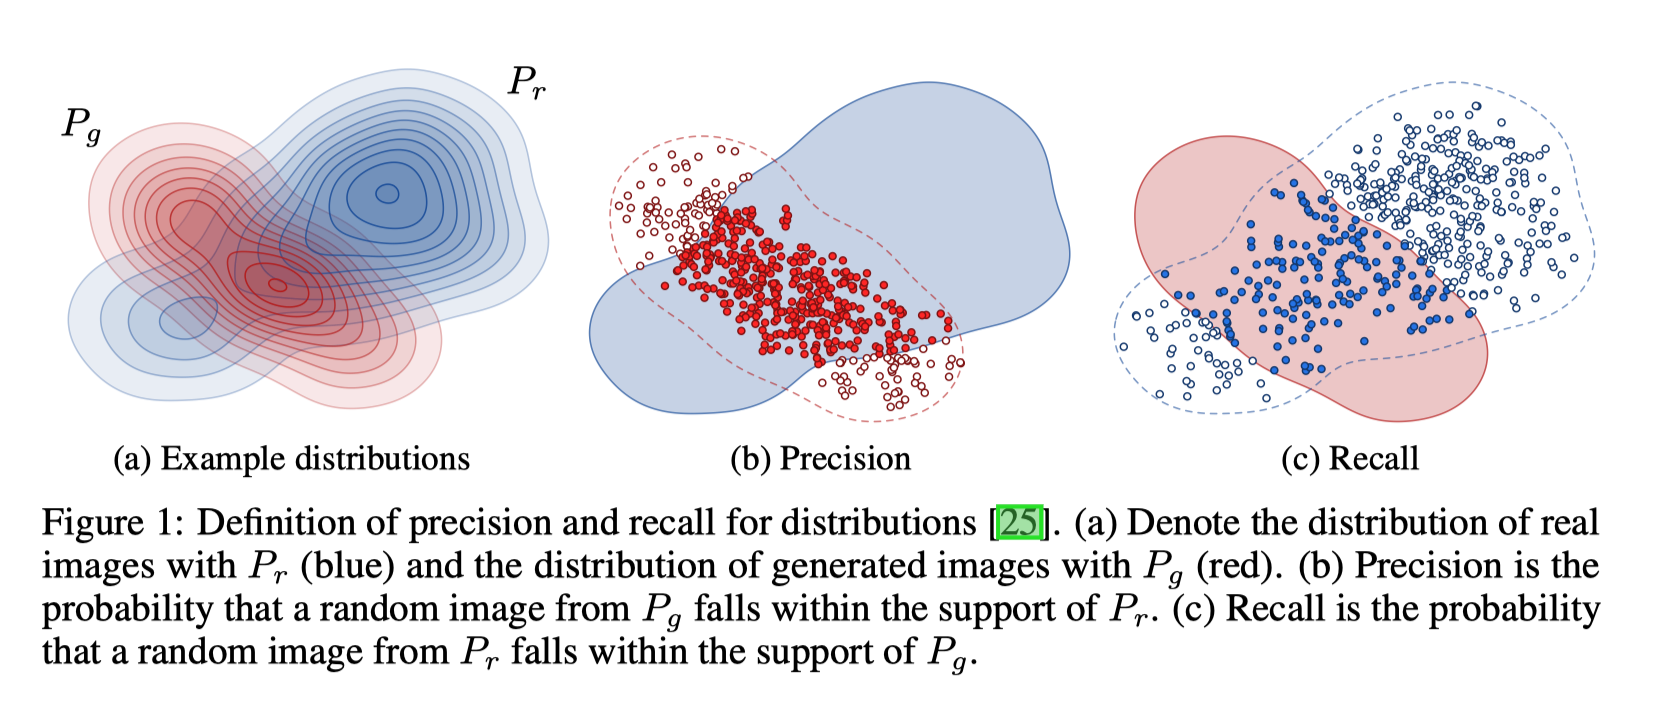

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_final_implement/notebook_images/pr_dbn.png", width =800)

# Improved precision recall metric

##Estimating learnt manifolds

>This paper argues that these classical concepts of precision and recall are sufficient to disentangle *sample quality* and *manifold coverage*. The metric outlined improves upon previous precision-recalls metrics, providing *explicit visibility of the trade-off between quality and variety.*
>
>In contrast to previous work, the metric suggested by this paper computes both precision and recall components as **expectations of binary set membership over a distribution**. This measures the *probability that an image drawn from one distribution falls under the support of the other distribution*. 
>
> To compute these components directly *adaptive-resolution finite approximations* are constructed for the *real* and *generated* manifolds. These *adaptive-resolution finite approximations* are able to answer binary membership queries, assessing if a sample lies in the support of a distribution.
>
> The key idea behind the metric presented it form **explicit non-parametric representations of the manifolds of real and generated data, from which precision and recall can be estimated**.
>
>Both distribution are sampled with real sample $X_{r} \sim P_{r}$ and generated sample $X_{r} \sim P_{r}$.
>
>These samples are then embedded into a high-dimensional feature space using a pre-trained classifier network. Each embedding represents a (potentially sparse) sample from the manifold.  The image are represented as manifold samples based on the features activated in the pre-trained model. 
>
>Within this implementation, the official Pytorch pre-trained VGG-16 network is used for this purpose. The corresponding activation layer after the second fully connected layer is extracted. This results in the respective feature vectors of $\phi_{r}$ and $\phi_{g}$ for particular images.  The respective set of feature vectors are $\Phi_{r}$ and $\Phi_{g}$. As equal number of samples from each distribution and $\left|\Phi_{r}\right|=\left|\Phi_{g}\right|$. By extracting each corpus of images into the same VGG-16 manifold space, both image sets have the same underlying representation. As such they may be easily compared within the shared manifold space. 
>
>*   For each set of feature vectors $\mathbf{\Phi} \in\left\{\mathbf{\Phi}_{r}, \mathbf{\Phi}_{g}\right\}$, the corresponding manifolds are estimated.
> 
>*   Computing pairwise Euclidean distances between all feature vectors in the set.
>
>*   For each feature vector, form a hypersphere with radius equal to the distance to the kth nearest neighbours. Each hypersphere encapsulates each vector's kth nearest neighbours. 
The result is a collection of hyperspheres that define a volume in the feature space. This is used as an estimate of the true manifold. 
>
>The technique has an elegant simplicity. The manifold is estimated by a collection of hyperspheres, each centred at an image's feature vector. Each of these hyperspheres has a radius set to encompass its k-nearest-neighbours. As such, the manifold can be represented by a collection of centre vectors and their corresponding radii. The extent to which another manifold in this feature space is contained within the orignal manifold may be assessed via simple distance calculation. The orignal manifold's vectors form the centre of each hypershere. Any point that lies outside these hyperspheres is not part of the orignal manifold. This may be checked by comparing the distance from this centre to it's hyperspheres' radius. 
>

 





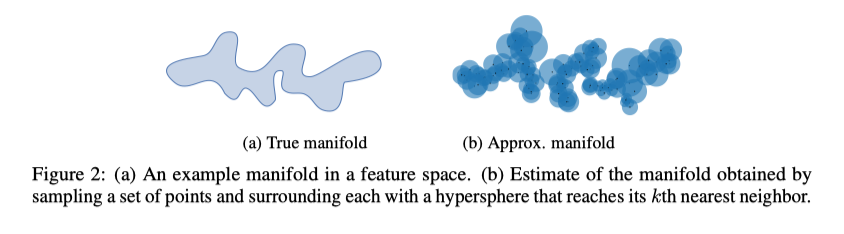

In [0]:
Image("/content/gdrive/My Drive/cv_final_implement/notebook_images/manifold.png", width =800) 

##Binary set membership

>Recall that this paper's metric quantifies precision and recall as expectations of binary set membership over a distribution. This measures the probability that an image drawn from one distribution falls under the support of the other distribution.
>
>The binary function that follows is used to determine if a sample $\phi$ is contained within the estimated manifold volume calculated above. 
>
>$f(\boldsymbol{\phi}, \mathbf{\Phi})=\left\{\begin{array}{l}{1, \text { if }\left\|\boldsymbol{\phi}-\boldsymbol{\phi}^{\prime}\right\|_{2} \leq\left\|\boldsymbol{\phi}^{\prime}-\mathbf{N N}_{k}\left(\boldsymbol{\phi}^{\prime}, \mathbf{\Phi}\right)\right\|_{2} \text { for at least one } \boldsymbol{\phi}^{\prime} \in \boldsymbol{\Phi}} \\ {0, \text { otherwise }}\end{array}\right.$
>
>Where $\mathrm{NN}_{k}\left(\phi^{\prime}, \mathbf{\Phi}\right)$ is the kth neareast feature vector   ${\phi}^{\prime}$ from the set $\mathbf{\Phi}$.
>
>
>*   $f(\boldsymbol{\phi}, \mathbf{\Phi_r})$ gives indication if image ${\phi}^{\prime}$ is realistic looking
>* $f(\boldsymbol{\phi}, \mathbf{\Phi_g})$ gives indication if image ${\phi}^{\prime}$ could be produced by the generator. 
>
## Improved metrics
> Precision is quantified by querying whether each generated image $\phi_{g}$ lies within the estimate o the real manifold $\mathbf{\Phi}_{r}$.
>
>*   $\operatorname{precision}\left(\mathbf{\Phi}_{r}, \mathbf{\Phi}_{g}\right)=\frac{1}{\left|\mathbf{\Phi}_{g}\right|} \sum_{\phi_{g} \in \Phi_{g}} f\left(\phi_{g}, \mathbf{\Phi}_{r}\right)$
>
>Symmetrically Recall is quantified by querying whether each real image $\phi_{r}$ lies within the estimate of the real manifold $\mathbf{\Phi}_{g}$
>
>* $\operatorname{recall}\left(\mathbf{\Phi}_{r}, \mathbf{\Phi}_{g}\right)=\frac{1}{\left|\mathbf{\Phi}_{r}\right|} \sum_{\boldsymbol{\phi}_{r} \in \mathbf{\Phi}_{r}} f\left(\boldsymbol{\phi}_{r}, \mathbf{\Phi}_{g}\right)$

## Pseudocode



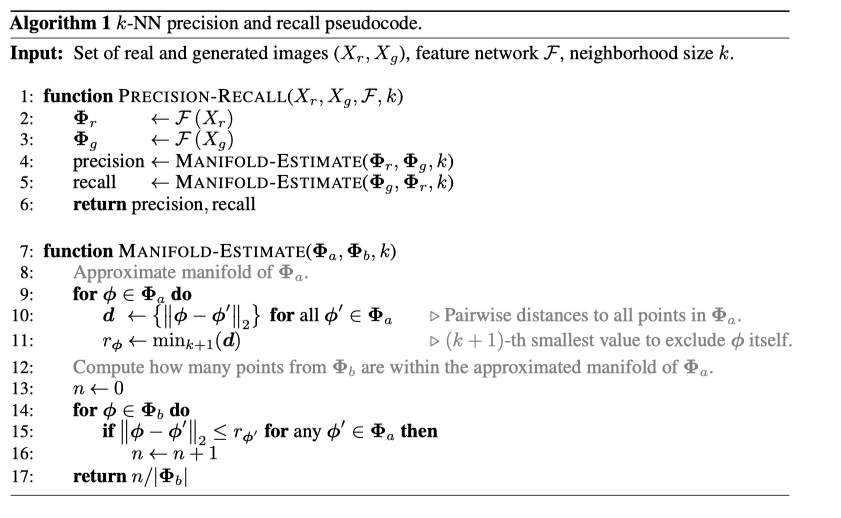

In [0]:
Image("/content/gdrive/My Drive/cv_final_implement/notebook_images/algo.png", width =800) 

# Implementation

##Data

####Fake
> The original paper focused on applying the outlined metric to *StyleGAN* and *BigGAN*. This implementation limits focus to *StyleGAN*. The "fake" generated images were sourced from the  the original [Nvidia Style GAN repro](https://github.com/NVlabs/stylegan), at truncation values of 0.5, 0.7 and 1.0. The choice of generative model for the "fake" images informs the "real" dataset.  The "real" dataset should align with the training data of the generative model.

####Real
>The StyleGAN used to generate the "fake" images were training using [Nvidia's Flickr-Faces-HQ Dataset (FFHQ) ](https://github.com/NVlabs/ffhq-dataset). As such these images were used as the "real" images. The FFHQ dataset is a high-quality image dataset of 70,000 1024x1024 images of human faces, originally created as a benchmark for generative adversarial networks (GAN). The dataset varies considerably over age, ethnicity and image background. There is also adequate presence of accessories such as eyeglasses, sunglasses, hats, etc. Images were crawled from Flickr and automatically aligned and cropped using dlib. Only images under permissive licenses were collected.

##Toolset

>It should be noted that both datasets are hosted on Google Drive, allowing them to be easily shared to one's Gdrive. This, coupled with access to free GPU acceleration, makes Google Colab an ideal tool for this purpose.

In [0]:
# Mounting Gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Checking virtual machine GPU and availability on Colab
!nvidia-smi

Sun Nov 24 11:17:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Checking virtual machine CPU
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits 

In [0]:
#Gdrive directory of pre-saved real images (from FFHQ repo)
cd /content/gdrive/My Drive/cv_final_implement/ffhq-dataset/images1024x1024

/content/gdrive/My Drive/cv_final_implement/ffhq-dataset/images1024x1024


In [0]:
# Content of pre-saved real image directory
ls

00000/  08000/  16000/  24000/  32000/  40000/  48000/  56000/  64000/
01000/  09000/  17000/  25000/  33000/  41000/  49000/  57000/  65000/
02000/  10000/  18000/  26000/  34000/  42000/  50000/  58000/  66000/
03000/  11000/  19000/  27000/  35000/  43000/  51000/  59000/  67000/
04000/  12000/  20000/  28000/  36000/  44000/  52000/  60000/  68000/
05000/  13000/  21000/  29000/  37000/  45000/  53000/  61000/  69000/
06000/  14000/  22000/  30000/  38000/  46000/  54000/  62000/  LICENSE.txt
07000/  15000/  23000/  31000/  39000/  47000/  55000/  63000/


(Sharable Gdrive link https://drive.google.com/open?id=1tZUcXDBeOibC6jcMCtgRRz67pzrAHeHL)

In [0]:
# Gdive directory of pre-saved fake images (from StyleGAN repo)
cd /content/gdrive/My Drive/cv_final_implement/stylegan/fake_stylegan_ffhq/ffhq-1024x1024

/content/gdrive/My Drive/cv_final_implement/stylegan/fake_stylegan_ffhq/ffhq-1024x1024


In [0]:
# Content of pre-saved fake image directory
# Each folder contains images generated at different truncation paramter values (psi)
ls

LICENSE.txt  psi-0.5/  psi-0.7/  psi-1.0/


(Sharable Gdrive link https://drive.google.com/open?id=14lm8VRN1pr4g_KVe6_LvyDX1PObst6d4)

In [0]:
# Importing necessary packages
import os
from functools import partial
from collections import namedtuple
from glob import glob
import numpy as np
from PIL import Image
from tqdm import tqdm, trange
import torch
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [0]:
#ImageFolder, FileNames class and get_custom_loader used as is from https://github.com/youngjung/improved-precision-and-recall-metric-pytorch/blob/master/improved_precision_recall.py

class ImageFolder(Dataset):
    def __init__(self, root, transform=None):
        # self.fnames = list(map(lambda x: os.path.join(root, x), os.listdir(root)))
        self.fnames = glob(os.path.join(root, '**', '*.jpg'), recursive=True) + \
            glob(os.path.join(root, '**', '*.png'), recursive=True)

        self.transform = transform

    def __getitem__(self, index):
        img_pth = self.fnames[index]
        image = Image.open(img_pth).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.fnames)


class FileNames(Dataset):
    def __init__(self, fnames, transform=None):
        self.fnames = fnames
        self.transform = transform

    def __getitem__(self, index):
        img_pth = self.fnames[index]
        image = Image.open(img_pth).convernvidt('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.fnames)
      
def get_custom_loader(image_dir_or_fnames, image_size=224, batch_size=50, num_workers=4, num_samples=-1):
    transform = []
    transform.append(transforms.Resize([image_size, image_size]))
    transform.append(transforms.ToTensor())
    transform.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225]))
    transform = transforms.Compose(transform)

    if isinstance(image_dir_or_fnames, list):
        dataset = FileNames(image_dir_or_fnames, transform)
    elif isinstance(image_dir_or_fnames, str):
        dataset = ImageFolder(image_dir_or_fnames, transform=transform)
    else:
        raise TypeError

    if num_samples > 0:
        dataset.fnames = dataset.fnames[:num_samples]
    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             pin_memory=True)
    return data_loader

In [0]:
num_samples = 10000 #Paper used 50k but 10k is usued for simplicity 
                    #"metric is weakly affected by the number of samples. Standard practice to quote FIDs w/ 50k samples"

def extract_features(img_pth, model=""):
    """
    
    (~ mapping in lines 2, 3 of Algo1)
    Extracts features from pre-trained VGG16-FC2 for every image img_pth
    
    Inputs:
    -img_path: string input of directory containing images 
    -model: this allows one to preload the model so that the default vgg model does not need to reload each time
    
    Outputs:
    -features: numpy array of features; dimension (number_of_images, number_of_features) 
    (number of features for pre-trained VGG-16 is 4096)
    
    Expected performace:
    - <10s/it on Tesla P100-PCIE 


    """
    if model == "":
      print('Loading pre-trained VGG16...', end='', flush=True)
      model = models.vgg16(pretrained=True).cuda().eval()
      print('Pre-trained VGG16 loaded.')
    else:
      model = model
      print('Input model loaded.')

    dataloader = get_custom_loader(img_pth, batch_size=50, num_samples=10000) #this function is used as is from https://github.com/youngjung/improved-precision-and-recall-metric-pytorch/blob/master/improved_precision_recall.py
    num_img_pth = len(dataloader.dataset) #total images found in img_pth
    desc = 'extracting features of %d images' % num_samples
    
    if num_img_pth < num_samples:
        print('WARNING: insufficient samples in img_pth - num_images_path(%d) < num_samples(%d)' % (num_img_pth, num_samples))

    features = []
    for batch in tqdm(dataloader, desc=desc):
        before_fc = model.features(batch.cuda())
        before_fc = before_fc.view(-1, 7 * 7 * 512)
        feature = model.classifier[:4](before_fc)
        features.append(feature.cpu().data.numpy())

    return np.concatenate(features, axis=0)

In [0]:
vgg16 = models.vgg16(pretrained=True).cuda().eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]


In [0]:
# saving to\loading from Gdrive 

#from numpy import asarray
#from numpy import savetxt
#savetxt("/content/gdrive/My Drive/cv_final_implement/notebook_save/real_feat.csv", fake_feat, delimiter=',')
#real_feat = loadtxt("/content/gdrive/My Drive/cv_final_implement/notebook_save/real_feat.csv", delimiter=',')

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/vgg16"
outfile = open(filename,'wb')
pickle.dump(vgg16,outfile)
outfile.close()

#infile = open(filename,'rb')
#vgg16 = pickle.load(infile)
#infile.close()

Running lines 2 & 3 of Algorithm 1, extracting features within the pretrained VGG-16 manifold  for  real and generated (fake) images.

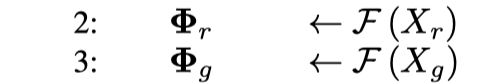

In [0]:
Image("/content/gdrive/My Drive/cv_final_implement/notebook_images/feat_extract.png", width =300)

In [0]:
#extracting features from real images
real_feat = extract_features("/content/gdrive/My Drive/cv_final_implement/ffhq-dataset/images1024x1024/")

Loading pre-trained VGG16...Pre-trained VGG16 loaded.


extracting features of 10000 images: 100%|██████████| 200/200 [07:57<00:00,  1.10s/it]


In [0]:
# saving to\loading from Gdrive 

#from numpy import asarray
#from numpy import savetxt
#savetxt("/content/gdrive/My Drive/cv_final_implement/notebook_save/real_feat.csv", fake_feat, delimiter=',')
#real_feat = loadtxt("/content/gdrive/My Drive/cv_final_implement/notebook_save/real_feat.csv", delimiter=',')

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/real_feat"
#outfile = open(filename,'wb')
#pickle.dump(real_feat,outfile)
#outfile.close()

infile = open(filename,'rb')
real_feat = pickle.load(infile)
infile.close()

In [0]:
#extracting features from fake images
fake_feat  = extract_features("/content/gdrive/My Drive/cv_final_implement/stylegan/fake_stylegan_ffhq/ffhq-1024x1024/psi-0.5")

In [0]:
# saving to\loading from Gdrive

#savetxt("/content/gdrive/My Drive/cv_final_implement/notebook_save/fake_feat.csv", fake_feat, delimiter=',')
#from numpy import loadtxt
#fake_feat = loadtxt("/content/gdrive/My Drive/cv_final_implement/notebook_save/fake_feat.csv", delimiter=',')

filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/fake_feat"
#outfile = open(filename,'wb')
#pickle.dump(fake_feat,outfile)
#$outfile.close()

infile = open(filename,'rb')
fake_feat = pickle.load(infile)
infile.close()

Specifying function to compute pairwise distances to all image features in a particular manifold *feat_A* as specified in lines 8 to 10 of Algorithm 1.

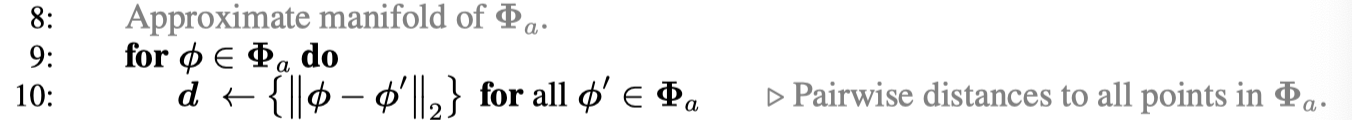

In [0]:
Image("/content/gdrive/My Drive/cv_final_implement/notebook_images/pairwised.png", width =800) 

The distance calculation that follows is able to calculate the distance between two feature vectors. In the pseudo code above, the pairwise distance between a vector and itself is required. However in *compute_metric()* below the distance between two vectors is needed. 

In [0]:
def compute_pairwise_dist(feat_A, feat_B=None):
    """""
    Inputs:
        -feat_A: numpy array of features; dimension (number_of_images, number_of_features)
        -feat_B: numpy array of features; dimension (number_of_images, number_of_features)
        
    Outputs:
        -d: numpy array of pairwise distances between each feature in feat_A; dimensions (number_of_images,number_of_images)
    """""
    num_feat_A = feat_A.shape[0]
    
    if feat_B is None:
        num_feat_B = num_feat_A
    else:
        num_feat_B = feat_B.shape[0]
        
    feat_A = feat_A.astype(np.float64)  # to prevent underflow
    feat_A_norm_sq = np.sum(feat_A**2, axis=1, keepdims=True)
    
    if feat_B is None:
        feat_B_norm_sq = feat_A_norm_sq
    else:
        feat_B_norm_sq = np.sum(feat_B**2, axis=1, keepdims=True)
    
    feat_A_sq = np.repeat(feat_A_norm_sq  , num_feat_B, axis=1)
    feat_B_sq = np.repeat(feat_B_norm_sq.T, num_feat_A, axis=0)
    
    if feat_B is None:
        feat_B = feat_A
    
    feat_AB = np.dot(feat_A, feat_B.T)
    diff_sq = feat_A_sq - 2*feat_AB + feat_B_sq

    # check negative distance
    min_diff_sq = diff_sq.min()
    if min_diff_sq < 0:
        idx = diff_sq < 0
        diff_sq[idx] = 0
        print('WARNING: %d negative diff_squares found and set to zero, min_diff_square=' % idx.sum(),
              min_diff_sq)

    d = np.sqrt(diff_sq)
    return d

In [0]:
#computing pairwise distances between real features
real_dist = compute_pairwise_dist(real_feat)

In [0]:
# saving to\loading from Gdrive 

#savetxt("/content/gdrive/My Drive/cv_final_implement/notebook_save/real_dist.csv", real_dist, delimiter=',')
#real_dist = loadtxt('"/content/gdrive/My Drive/cv_final_implement/notebook_save/real_dist.csv"', delimiter=',')

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/real_dist"
#outfile = open(filename,'wb')
#pickle.dump(real_dist,outfile)
#outfile.close()

infile = open(filename,'rb')
real_dist = pickle.load(infile)
infile.close()

In [0]:
#computing pairwise distances between fake features
fake_dist = compute_pairwise_dist(fake_feat)

In [0]:
# saving to\loading from Gdrive 

#savetxt("/content/gdrive/My Drive/cv_final_implement/notebook_save/fake_dist.csv", fake_dist, delimiter=',')
#fake_dist = loadtxt('"/content/gdrive/My Drive/cv_final_implement/notebook_save/real_dist.csv"', delimiter=',')

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/fake_dist"
#outfile = open(filename,'wb')
#pickle.dump(fake_dist,outfile)
#outfile.close()

infile = open(filename,'rb')
fake_dist = pickle.load(infile)
infile.close()

Specifying functions to calculate radius $r_\phi$ around $\phi$ in lines 11 of Algorithm 1. This is needed to estimate the manifold as a collection of hyperspheres that encapsulate each vector's K-Nearest Neighbours.

In [0]:
Image("/content/gdrive/My Drive/cv_final_implement/notebook_images/rad.png", width =600) 

In [0]:
def get_kth_NN(np_array, k):
  """""
  Inputs:
      -np_array: numpy array of values 
      -k: number of Nearest Neibours that should be returned 

  Outputs:
      - kth_NN: kth nearest neighbour 
  """""
  idx = np.argpartition(np_array, k+1)
  k_smallest = np_array[idx[:(k+1)]]
  kth_NN = k_smallest.max()
  return kth_NN

In [0]:
def dist2radii(dist, k=3):
    num_feat = dist.shape[0]
    radii = np.zeros(num_feat)
    for i in range(num_feat):
        radii[i] = get_kth_NN(dist[i], k=k)
    return radii

The manifold estimate is assumed to be a set of hyperspheres, each centred at the feature vector in the VGG-16 manifold $\phi$ with radius $\phi$. As such the the manifold $\mathbf{\Phi}$ can be expressed as a set of feature vectors and their corresponding radii. This is captured in named tuple *'manifold'*.

In [0]:
from collections import namedtuple
manifold = namedtuple('manifold', ['feat', 'radii']) #creating namedtuple 'manifold'

In [0]:
def compute_manifold(x_feat,k=3):
  """""
  Inputs:
      -x_feat: extracted features from dataset as output by extract_features()  
      -k: number of Nearest Neibours used in manifold estimation (default set to paper value of 3)

  Outputs:
      - manifold(x_feat, radii): namedtuple('manifold', ['feat', 'radii'])
          - manifold.feat
          - manifold.radii
  """""

  dist = compute_pairwise_dist(x_feat)
  radii = dist2radii(dist, k=k)
  return manifold(x_feat, radii)


In [0]:
real_manifold = compute_manifold(real_feat)

In [0]:
# saving to\loading from Gdrive 

filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/real_manifold"
#outfile = open(filename,'wb')
#pickle.dump(real_manifold,outfile)
#outfile.close()

infile = open(filename,'rb')
real_manifold = pickle.load(infile)
infile.close()

In [0]:
fake_manifold = compute_manifold(fake_feat)

In [0]:
fake_manifold

manifold(feat=array([[-1.66858554, -1.85307121,  0.08230425, ..., -1.76788127,
        -0.54267603, -1.75066686],
       [-1.67326307, -2.42841792, -0.36088097, ..., -1.05945551,
        -1.70686865, -2.09527707],
       [-2.75285745, -0.88105851, -0.60639483, ..., -1.93179357,
         0.00981366, -2.53114724],
       ...,
       [-3.38533139, -3.33632541, -1.32397938, ..., -2.02854943,
         0.61531663, -0.9685877 ],
       [-2.39822412, -1.94308829,  0.30748403, ..., -2.20571542,
        -0.92460048, -2.05901933],
       [-2.23364115, -1.60680294, -1.6939007 , ..., -1.27839887,
        -1.57707298, -1.52163267]]), radii=array([30.47582366, 30.63872344, 27.2263676 , ..., 30.04417086,
       32.36590658, 42.9731605 ]))

In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/fake_manifold"
#outfile = open(filename,'wb')
#pickle.dump(fake_manifold,outfile)
#outfile.close()

infile = open(filename,'rb')
fake_manifold = pickle.load(infile)
infile.close()

Specifying functions to calculate number of features in one manifold that lie within another manifold. These functions implement lines 12 to 17 of Algorithm 1.



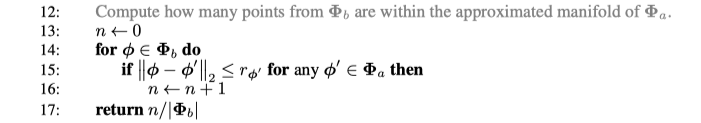

In [0]:
Image("/content/gdrive/My Drive/cv_final_implement/notebook_images/bin_set_memb.png", width =600) 

In [0]:
def compute_metric(manifold, feat_subject, desc=''):
  
    """""
  Inputs:
      - manifold(x_feat, radii): namedtuple('manifold', ['feat', 'radii']) as ouput by compute_manifold()
          - manifold.feat
          - manifold.radii  
          
      - feat_subject: numpy array of features; dimension (number_of_images, number_of_features), as output by extract_features()
                      (number of features for pre-trained VGG-16 is 4096)
  Outputs:
      - proportion of feat_subject vectors estimated top in manifold
  """""
  
 
    num_subject_samples = feat_subject.shape[0]
    count = 0
    dist = compute_pairwise_dist(manifold.feat, feat_subject)
    for i in trange(num_subject_samples, desc=desc):
        count += (dist[:, i] < manifold.radii).any() # for each feature in subject check if the distance from manifold.feat is within corresponding manifold.radii
    return count / num_subject_samples

In [0]:
def precision_recall(real_manifold, fake_manifold):
  """
  Inputs:
      - real_manifold(feat, radii): namedtuple('manifold', ['feat', 'radii']) as ouput by compute_manifold()
          - manifold.feat
          - manifold.radii  
          
      - real_manifold(feat, radii): namedtuple('manifold', ['feat', 'radii']) as ouput by compute_manifold()
          - manifold.feat
          - manifold.radii
  Outputs:
      - named tuple metrics(precision, recall)
  """
  
  precision = compute_metric(real_manifold,fake_manifold.feat, "computing precision...")
  print("\n precision: \n", precision)
  recall = compute_metric(fake_manifold,real_manifold.feat, "computing recall...")
  print("\n recall: \n ", recall)
  
  return precision, recall
                
 
 
  



In [0]:
p1, r1 = precision_recall(real_manifold, fake_manifold)

computing precision...: 100%|██████████| 10000/10000 [00:00<00:00, 16413.15it/s]



 precision: 
 0.8854


computing recall...: 100%|██████████| 10000/10000 [00:01<00:00, 5369.78it/s]


 recall: 
  0.1816


In [0]:
print(p1,r1)

0.8854 0.1816


In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/p1"
outfile = open(filename,'wb')
pickle.dump(p1,outfile)
outfile.close()

#infile = open(filename,'rb')
#p1 = pickle.load(infile)
#infile.close()

In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/r1"
outfile = open(filename,'wb')
pickle.dump(r1,outfile)
outfile.close()

#infile = open(filename,'rb')
#r1 = pickle.load(infile)
#infile.close()

In [0]:
fake_feat2 = extract_features("/content/gdrive/My Drive/cv_final_implement/stylegan/fake_stylegan_ffhq/ffhq-1024x1024/psi-0.7",vgg16)


Input model loaded.


extracting features of 10000 images: 100%|██████████| 200/200 [22:56<00:00,  3.66s/it]


In [0]:
fake_feat2

array([[-1.798691  , -0.21476349, -0.17976691, ..., -2.130951  ,
        -1.2713699 , -3.0069895 ],
       [-1.3368604 , -1.7120419 ,  0.3539417 , ..., -2.6430078 ,
        -2.3624976 , -1.8485229 ],
       [-4.323743  , -2.089777  ,  2.5439227 , ..., -1.6618332 ,
        -0.6916375 , -2.7899966 ],
       ...,
       [-1.0976303 ,  0.50713444, -0.9415493 , ..., -1.2381097 ,
        -1.166658  , -1.1567334 ],
       [-1.5984919 , -1.1663864 , -0.56414104, ..., -1.9968797 ,
        -1.1945242 , -2.11435   ],
       [-2.3360233 , -3.0557268 ,  0.48005846, ..., -2.2001853 ,
        -2.7627327 , -2.2626774 ]], dtype=float32)

In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/fake_feat2"
outfile = open(filename,'wb')
pickle.dump(fake_feat2,outfile)
outfile.close()

#infile = open(filename,'rb')
#fake_feat2 = pickle.load(infile)
#infile.close()

In [0]:
fake_manifold2 = compute_manifold(fake_feat2)

In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/fake_manifold2"
outfile = open(filename,'wb')
pickle.dump(fake_manifold2,outfile)
outfile.close()

#infile = open(filename,'rb')
#fake_manifold2 = pickle.load(infile)
#infile.close()

In [0]:
p2, r2 = precision_recall(real_manifold, fake_manifold2)

computing precision...: 100%|██████████| 10000/10000 [00:02<00:00, 4488.42it/s]



 precision: 
 0.8464


computing recall...: 100%|██████████| 10000/10000 [00:02<00:00, 4403.81it/s]


 recall: 
  0.3366


In [0]:
print(p2,r2)

0.8464 0.3366


In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/p2"
outfile = open(filename,'wb')
pickle.dump(p2,outfile)
outfile.close()

#infile = open(filename,'rb')
#p2 = pickle.load(infile)
#infile.close()

In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/r2"
outfile = open(filename,'wb')
pickle.dump(r2,outfile)
outfile.close()

#infile = open(filename,'rb')
#r2 = pickle.load(infile)
#infile.close()

In [0]:
fake_feat3 = extract_features("/content/gdrive/My Drive/cv_final_implement/stylegan/fake_stylegan_ffhq/ffhq-1024x1024/psi-1.0", vgg16)


Input model loaded.


extracting features of 10000 images: 100%|██████████| 200/200 [28:43<00:00,  8.91s/it]


In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/fake_feat3"
outfile = open(filename,'wb')
pickle.dump(fake_feat3,outfile)
outfile.close()

#infile = open(filename,'rb')
#fake_feat3 = pickle.load(infile)
#infile.close()

In [0]:
fake_manifold3 = compute_manifold(fake_feat3)

In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/fake_manifold3"
outfile = open(filename,'wb')
pickle.dump(fake_manifold3,outfile)
outfile.close()

#infile = open(filename,'rb')
#fake_manifold3 = pickle.load(infile)
#infile.close()

In [0]:
p3, r3 = precision_recall(real_manifold, fake_manifold3)

In [0]:
print(p3,r3)

0.7781 0.4704


In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/p3"
outfile = open(filename,'wb')
pickle.dump(p3,outfile)
outfile.close()

#infile = open(filename,'rb')
#p3 = pickle.load(infile)
#infile.close()

In [0]:
# save to/load from Gdrive

import pickle
filename = "/content/gdrive/My Drive/cv_final_implement/notebook_save/r3"
outfile = open(filename,'wb')
pickle.dump(r3,outfile)
outfile.close()

#infile = open(filename,'rb')
#r3 = pickle.load(infile)
#infile.close()

In [0]:
def precision_recall_img_pth(real_img_pth, fake_img_pth, k=3):
    """

    (~ Algo1)
    Returns precision-recall from image input paths, combining all previous steps

    Inputs:
    -real_img_pth: string input of directory containing real images
    -fake_img_pth: string input of directory containing fake images 

    Outputs:
    -precision-recall

    """
    #extracting features from real images
    print("extracting features from real images...")
    real_feat = extract_features(real_img_pth, vgg16)

    #extracting features from real images
    print("extracting features from fake images...")
    fake_feat = extract_features(fake_img_pth, vgg16)

    #computing real_manifold
    print("computing real manifold...")
    real_manifold = compute_manifold(real_feat,k)

    #computing fake
    print("computing fake manifold...")
    fake_manifold = compute_manifold(fake_feat,k)

    #computing precision_recall
    print("computing precision_recall...")

    precision_recall(real_manifold, fake_manifold)

  

In [0]:
precision_recall_img_pth("/content/gdrive/My Drive/cv_final_implement/ffhq-dataset/images1024x1024/","/content/gdrive/My Drive/cv_final_implement/stylegan/fake_stylegan_ffhq/ffhq-1024x1024/psi-0.5")

As expected as the truncation paramater of the StyleGAN increases an precission-recall trade-off is observed.

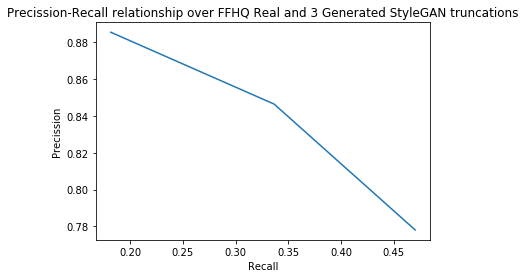

In [0]:
import matplotlib.pyplot as plt 

# recal values 
r = [r1, r2,r3] 
# corresponding precisson values 
p = [p1, p2, p3]   
# plotting the points  
plt.plot(r, p) 
  
plt.xlabel('Recall') 
plt.ylabel('Precission') 
plt.title('Precission-Recall relationship over FFHQ Real and 3 Generated StyleGAN truncations') 
  
# function to show the plot 
plt.show() 

The graph above is based on the 3 trancation value fake datasets shared on the StyleGan repo. While limited, it exhibits the expected trade-off relationship of the paper. The relationship of the paper's experiments are seen below. 

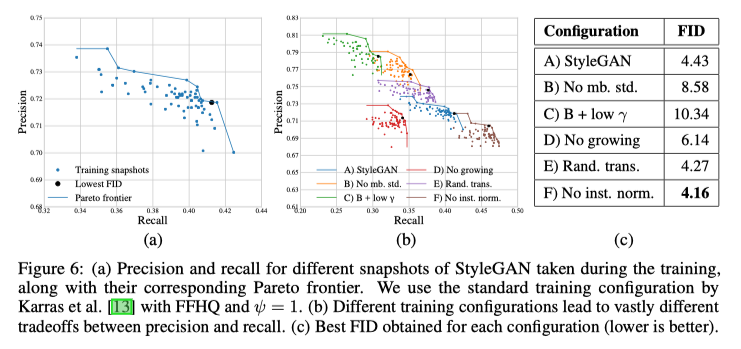

In [0]:
Image("/content/gdrive/My Drive/cv_final_implement/notebook_images/prcurve.png", width =600) 

# Scope for further research

>It is likely that the manifold representation proposed by this paper is "patchy" and disconnected.  It's coverage may even become increasingly sparse as the dimensionality of the manifold space increases. Testing the extent of this may shed light into how the current manifold representation, and thus precision-recall metric, may be improved. Measuring how many hyperspheres intersect their neighbours may prove to be a insightful measure. In addition, understanding how many binary set membership counts were missed as a result of potential manifold representation "patchiness" would be useful. 

#References

>  [[1]](https://arxiv.org/abs/1904.06991)  T. Kynkäänniemi, T. Karras, S. Laine, J. Lehtinen and T. Aila, "Improved Precision and Recall Metric for Assessing Generative Models", arXiv.org, 2019. [Online]. Available: https://arxiv.org/abs/1904.06991. [Accessed: 20- Nov- 2019].
>
>
>  [[2]](https://arxiv.org/abs/1806.00035)  M. Sajjadi, O. Bachem, M. Lucic, O. Bousquet and S. Gelly, "Assessing Generative Models via Precision and Recall", arXiv.org, 2019. [Online]. Available: https://arxiv.org/abs/1806.00035. [Accessed: 20- Nov- 2019].
>
>
>  [[3]](https://github.com/kynkaat/improved-precision-and-recall-metric) "kynkaat/improved-precision-and-recall-metric", GitHub, 2019. [Online]. Available: https://github.com/kynkaat/improved-precision-and-recall-metric. [Accessed: 20- Nov- 2019].
>
>
>  [[4]](https://github.com/youngjung/improved-precision-and-recall-metric-pytorch)  "youngjung/improved-precision-and-recall-metric-pytorch", GitHub, 2019. [Online]. Available: https://github.com/youngjung/improved-precision-and-recall-metric-pytorch. [Accessed: 20- Nov- 2019].
>
>
>  [[5]](https://github.com/NVlabs/stylegan)   "NVlabs/stylegan", GitHub, 2019. [Online]. Available: https://github.com/NVlabs/stylegan. [Accessed: 20- Nov- 2019].
>
>
>  [[6]](https://github.com/kynkaat/improved-precision-and-recall-metric)  "kynkaat/improved-precision-and-recall-metric", GitHub, 2019. [Online]. Available: https://github.com/kynkaat/improved-precision-and-recall-metric. [Accessed: 20- Nov- 2019].

# Resources
>*   Colab Notebook share link:
https://colab.research.google.com/drive/1Ia5AJ30lwhgUIPD_HY7SXrOGxXSBPZQp
>
>
>*   Working Folder Gdrive share link:
https://drive.google.com/drive/folders/1Jj48v5iqKxug70rvFE_gBJZYOgTqcPeD?usp=sharing
>
>*   FFHQ Real Dataset Gdrive share link: https://drive.google.com/open?id=1tZUcXDBeOibC6jcMCtgRRz67pzrAHeHL
>
>*   StyleGAN Fake Dataset Gdrive link: https://drive.google.com/open?id=14lm8VRN1pr4g_KVe6_LvyDX1PObst6d4)

# Appendix

>Pre-trained VGG Architecture 

In [0]:
print('Loading pre-trained VGG16...', end='', flush=True)
vgg16 = models.vgg16(pretrained=True).cuda().eval()
print('Pre-trained VGG16 loaded.')
print(vgg16)

Loading pre-trained VGG16...Pre-trained VGG16 loaded.
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Ma